<a href="https://colab.research.google.com/github/dougscohen/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [110]:
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [111]:
# Looking at datatypes of columns and specifically the 'Date' column 

df.dtypes.head()

Burrito     object
Date        object
Yelp       float64
Google     float64
Chips       object
dtype: object

In [0]:
# Use pandas to_datetime function to turn 'Date' column into datetime format

import pandas as pd

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [113]:
# Look at values in 'Date' column

df['Date']

0     2016-01-18
1     2016-01-24
2     2016-01-24
3     2016-01-24
4     2016-01-27
         ...    
418   2019-08-27
419   2019-08-27
420   2019-08-27
421   2019-08-27
422   2019-08-27
Name: Date, Length: 421, dtype: datetime64[ns]

In [0]:
# Establish cutoffs so that we can separate our dataframe by dates

cutoff_1 = pd.to_datetime('2017-01-01')
cutoff_2 = pd.to_datetime('2018-01-01')

# Train dataset will include all observations before 2017
train = df[df['Date'] < cutoff_1]

# Validate dataset will include all observations in 2017
val = df[(df['Date'] >= cutoff_1) & (df['Date'] < cutoff_2)]

# Test dataset will include all observations after in 2018 and later
test = df[df['Date'] >= cutoff_2]

In [115]:
print(train.shape)
train.head()

(298, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [116]:
print(val.shape)
val.head()

(85, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
301,California,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
302,Other,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
303,Other,2017-01-07,NaN,NaN,NaN,8.50,3.9,NaN,NaN,21.0,21.0,0.74,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
304,Other,2017-01-07,NaN,NaN,NaN,7.90,4.0,NaN,NaN,20.5,21.0,0.72,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
305,Other,2017-01-10,NaN,NaN,NaN,4.99,3.5,NaN,NaN,18.5,22.5,0.75,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [117]:
print(test.shape)
test.head()

(38, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,2018-01-09,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,2018-01-12,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,2018-01-12,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [118]:
# Baseline for Classification

target = 'Great'
y_train = train[target]
y_val = val[target]

y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
# Majority Class is that a burrito is Not Great

In [120]:
majority_class = y_train.mode()[0]

# Guessing the majority class for every prediction
y_pred_base = [majority_class] * len(y_train)
y_pred_base

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [0]:
from sklearn.metrics import accuracy_score

In [122]:
# Baseline accuracy if we guessed the majority class (Not a great burrito) 
# for every predicition

accuracy_score(y_train, y_pred_base)

0.5906040268456376

In [123]:
# Looking at the categorical columns

train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
Chile relleno,4,1,x,4,NaT,NaT
Ham,1,1,x,1,NaT,NaT
Zucchini,1,1,x,1,NaT,NaT
Nopales,4,1,x,4,NaT,NaT
Lobster,1,1,x,1,NaT,NaT
Egg,4,1,x,4,NaT,NaT
Carrots,1,1,x,1,NaT,NaT
Bacon,3,1,x,3,NaT,NaT
Sushi,2,1,x,2,NaT,NaT
Unreliable,27,1,x,27,NaT,NaT


In [124]:
# Look at numerical columns

train.describe(include='number')

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [125]:
train.describe(include='number').columns

Index(['Yelp', 'Google', 'Cost', 'Hunger', 'Mass (g)', 'Density (g/mL)',
       'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Queso'],
      dtype='object')

In [0]:
# 1. Import estimator class
from sklearn.linear_model import LogisticRegression

# 2. Substantiate the class
log_reg = LogisticRegression()

# 3. Arrange X features matrix (already did y target vectors)
# Take out columns that are entirely NaNs ('Mass (g), 'Density (g/mL), and 'Queso)
features = ['Yelp', 'Google', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume',
            'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling',
            'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Burrito']

X_train = train[features]
X_val = val[features]

# One hot encode the 'Burrito' column
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Impute Missing Values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# Standardize the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [127]:
# 4. Fit the model 

log_reg.fit(X_train_scaled, y_train)

# 5. Apply the model to the new data

log_reg.predict(X_val_scaled)

array([ True, False,  True,  True, False, False,  True,  True, False,
        True,  True, False, False, False,  True, False, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True, False, False,  True, False, False,
       False,  True, False,  True, False, False,  True,  True,  True,
        True, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False,  True,  True])

In [128]:
# Predicting the dependent variable (whethere a burrito is great)
# on the Validation set using Logistic Regression

y_pred_log = log_reg.predict(X_val_scaled)

# Accuracy of the model 

accuracy_score(y_val, y_pred_log)

0.8235294117647058

In [129]:
# Coefficients

log_reg.coef_

array([[ 0.15856382,  0.01397665,  0.42229548,  0.10098178,  0.2254364 ,
         0.01115175, -0.01988395,  0.70335941,  0.64313555,  1.33840237,
         1.18782075,  1.39163215,  0.11512039,  0.29689514,  1.6903248 ,
         0.13433672,  0.24613973,  0.22868069, -0.03707388, -0.20164471,
        -0.23256147]])

In [130]:
from sklearn.linear_model import LogisticRegressionCV

# Fitting logistic regression CV to the data

log_reg_CV = LogisticRegressionCV()
log_reg_CV.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [131]:
# Predicting whether a burrito is great or not based on Logistic Regression CV

y_pred_logCV = log_reg_CV.predict(X_val_scaled)

# Accuracy of the model 

accuracy_score(y_val, y_pred_logCV)

0.8470588235294118

In [132]:
log_reg_CV.intercept_

array([-0.7585968])

In [133]:
# Coefficients

log_reg_CV.coef_

array([[ 0.09248708, -0.00314032,  0.22270698,  0.10373385,  0.04533522,
         0.00101592,  0.00494777,  0.31711707,  0.27426684,  0.58540718,
         0.56801288,  0.50276533,  0.1848322 ,  0.25109919,  0.66623089,
         0.07335494,  0.136708  ,  0.02633738, -0.00496958, -0.08523777,
        -0.11603659]])

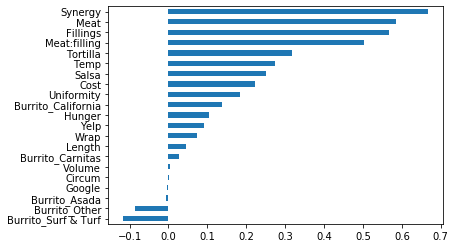

In [134]:
# Plotting the coefficients to see which independant variables are most 
# strongly correlated with the dependant variable

import matplotlib.pyplot as plt
%matplotlib inline

coefficients = pd.Series(log_reg_CV.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

In [135]:
# Predict whether or not a burrito is great on the test data

X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)

y_pred_final = log_reg_CV.predict(X_test_scaled)
y_pred_final

array([ True,  True, False,  True, False, False,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False, False,  True, False,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True])